In [1]:
# Data processing
import pandas as pd
import numpy as np
import seaborn as sns

# Standardize the data (padronização)
from sklearn.preprocessing import StandardScaler

# Modeling 
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings("ignore")
# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

In [2]:
# vamos importar a base de produção de energia elétrica
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/pld_norte.csv', index_col='inicio_semana', parse_dates=True)
# df = pd.read_csv('C:\projetos\jupyter_notebook\hyperparams_optimization\_data\pld_norte.csv', index_col='inicio_semana', parse_dates=True)

# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,preco_pesado,preco_medio,preco_leve,geracao_hidraulica,geracao_termica,carga_energia,reservatorio_EARM,reservatorio_ENA
inicio_semana,,,,,,,,
2001-08-04,684.0,684.0,684.0,2952.29,0.0,2204.00,62.42,89.57
2001-08-11,684.0,684.0,684.0,2956.57,0.0,2141.57,59.75,88.57
2001-08-18,684.0,684.0,684.0,2909.71,0.0,2110.43,56.75,83.86
2001-08-25,684.0,684.0,684.0,2631.00,0.0,2095.43,53.63,79.29
2001-09-01,684.0,684.0,684.0,2558.86,0.0,2069.14,50.64,76.00


In [3]:
df = df.drop(columns=['preco_pesado','preco_leve','geracao_hidraulica','geracao_termica','carga_energia','reservatorio_EARM','reservatorio_ENA'])
# df = df[23:len(df)-22]
df

,preco_medio
inicio_semana,
2001-08-04,684.00
2001-08-11,684.00
2001-08-18,684.00
2001-08-25,684.00
2001-09-01,684.00
...,...
2009-11-28,16.31
2009-12-05,16.31
2009-12-12,16.31


Text(0, 0.5, 'Preço médio (R$)')

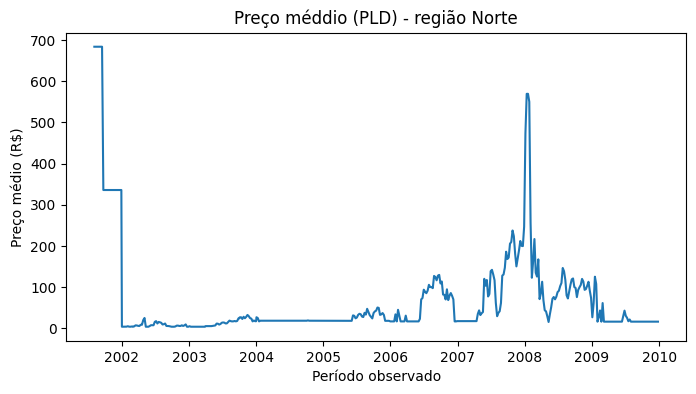

In [4]:
plt.subplots(figsize=(8,4))
plt.plot(df)
plt.title('Preço méddio (PLD) - região Norte')
plt.xlabel('Período observado')
plt.ylabel('Preço médio (R$)')

## Pré-processamento
> Separação dos dados em treino / teste

In [5]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [6]:
train, test = split_dataset(df, 0.75, True)


BASE DE TREINO
                preco_medio
inicio_semana             
2007-10-06          172.08
2007-10-13          205.54
2007-10-20          209.96
2007-10-27          237.66
2007-11-03          223.89

BASE DE TESTE
                preco_medio
inicio_semana             
2007-11-10          181.30
2007-11-17          150.54
2007-11-24          169.65
2007-12-01          189.25
2007-12-08          212.20


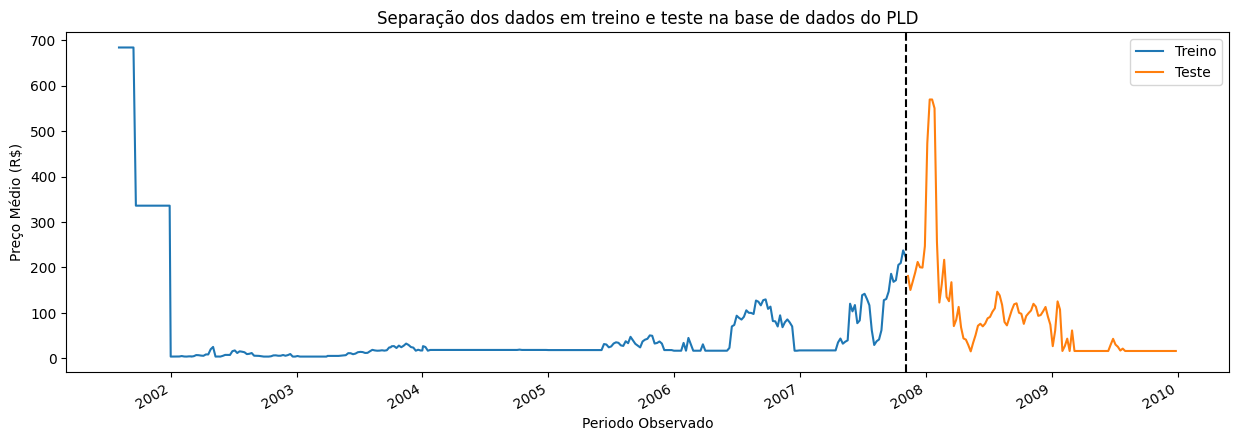

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Treino', title='Separação dos dados em treino e teste na base de dados do PLD')
test.plot(ax=ax, label='Teste')
ax.axvline('2007-11-03', color='black', ls='--')
ax.legend(['Treino', 'Teste'])
plt.xlabel("Periodo Observado")
plt.ylabel("Preço Médio (R$)")
plt.show()

> Feature Engineering

In [10]:
def series_to_supervised(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['t-'+str(i)] = serie.shift(i)
    features = features.iloc[steps_in:] # remove linhas iniciais com nan
    return features

In [13]:
def lags(steps):
    lags_model = []
    for i in range(1, steps+1):
        # Feature Engireering
        train_data_features = series_to_supervised(train, steps_in=i)
        test_data_features = series_to_supervised(test, steps_in=i)

        # define X e y
        X_train = train_data_features.drop(columns=['t']).values
        y_train = train_data_features['t'].values.reshape(-1, 1)
        X_test = test_data_features.drop(columns=['t']).values
        y_test = test_data_features['t'].values.reshape(-1, 1)

        # padronização dos dados
        sc = StandardScaler()
        X_train_transformed = pd.DataFrame(sc.fit_transform(X_train))
        X_test_transformed = pd.DataFrame(sc.transform(X_test))

        # Define o modelo com os parametros padrões
        svr = SVR()
        svr.fit(X_train_transformed, y_train)

        # Verifica a acurácia
        score = svr.score(X_test_transformed, y_test)
        lags_model.append(score)
        print(f'O ponto de acurácia do modelo com {i} lags tem {score:.4f}')
    print("\n===================================================")
    print("Melhor pontuação de acurárcia: {}".format(max(lags_model)))
    print("===================================================")
lags(100)

O ponto de acurácia do modelo com 1 lags tem 0.0706
O ponto de acurácia do modelo com 2 lags tem 0.0483
O ponto de acurácia do modelo com 3 lags tem 0.0221
O ponto de acurácia do modelo com 4 lags tem 0.0024
O ponto de acurácia do modelo com 5 lags tem -0.0150
O ponto de acurácia do modelo com 6 lags tem -0.0238
O ponto de acurácia do modelo com 7 lags tem -0.0332
O ponto de acurácia do modelo com 8 lags tem -0.0370
O ponto de acurácia do modelo com 9 lags tem -0.0371
O ponto de acurácia do modelo com 10 lags tem -0.0261
O ponto de acurácia do modelo com 11 lags tem 0.0093
O ponto de acurácia do modelo com 12 lags tem 0.0924
O ponto de acurácia do modelo com 13 lags tem 0.1159
O ponto de acurácia do modelo com 14 lags tem 0.0981
O ponto de acurácia do modelo com 15 lags tem 0.0895
O ponto de acurácia do modelo com 16 lags tem 0.1015
O ponto de acurácia do modelo com 17 lags tem 0.0936
O ponto de acurácia do modelo com 18 lags tem 0.0926
O ponto de acurácia do modelo com 19 lags tem 0.1